<h1 style="text-align: center;">Stroke Prediction</h1>

<h3 style="text-align: center;">3. ANN optimization with GridSearchCV</h3>

<p style="text-align: center;">Hugo Gálvez</p>

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import joblib

# Scikit-learn: preprocessing, models, metrics, and cross-validation
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

# Imbalanced-learn: SMOTENC
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

# TensorFlow and Keras: creating and training ANN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

# Visualization in Jupyter Notebook
from IPython.display import display, Markdown

## Data Loading

In this section, we prepare the data for analysis and optimization using `GridSearchCV`, preprocessing it in the same way as in the model comparison.

Key parameters, such as the indices of categorical variables and the fitted preprocessor, are stored, and class weights are specified to handle the dataset's imbalance during the modeling process. This configuration is essential for effectively optimizing and evaluating the models.

In [2]:
data = pd.read_csv('cleaned_healthcare_dataset.csv')

# Set the global seed
seed = 12345
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Separate features and target variable
X = data.drop(columns=['stroke'])
y = data['stroke']

# Split the data into training (67%) and test (33%) with seed = 12345
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=seed, stratify=y
)

# Column configuration
categorical_features = [
    'gender', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'smoking_status'
]
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Encode categorical variables with OneHotEncoder and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Determine input dimensions
input_dim = X_train_transformed.shape[1]

# Identify the indices of categorical features after preprocessing
categorical_indices = list(range(len(numerical_features), 
                                  len(numerical_features) +
                                  len(categorical_features)))

# Cross-validation configuration
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame()

# Define class weights
class_weights = {0: 1.0, 1: 2}

# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

To define class weights, several strategies such as `class_weight='balanced'` were tested, but the weight assigned to `stroke` was too high and negatively impacted the efficiency of the ANN. After several manual tests, weights were determined as `1:2`, which provided the most balanced metrics for both classes.

## ANN Function

We define a function to create Artificial Neural Network (ANN) models with a customizable architecture. The function allows adjusting key parameters such as the number of hidden layers, dropout rate to prevent overfitting, learning rate, and input dimensions for the model.

The model uses dense layers with ReLU activation to capture non-linear relationships and ends with a sigmoid output layer for binary predictions. Additionally, it is compiled with the Adam optimizer, which combines efficiency and stability, and is evaluated using the `binary_crossentropy` loss function, suitable for binary classification problems, along with `accuracy` and AUC metrics to measure overall performance.

Finally, an instance of the model is generated with the defined configuration, and `summary()` is used to visualize the architecture, allowing for a review of its design before training.

In [3]:
def create_model(layers=(50,),
                       dropout_rate=0.3,
                       learning_rate=0.001,
                       input_dim=None):  
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for units in layers:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])
    return model

model = create_model(input_dim=input_dim)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,001 (3.91 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

## GridSearchCV Configuration

In this section, we set up the optimization pipeline for Artificial Neural Networks (ANN) using `GridSearchCV`. First, we create a `KerasClassifier` wrapper that converts our Keras model into a `scikit-learn`-compatible estimator, simplifying the hyperparameter search process. This wrapper allows tuning key aspects of the model, such as layer architecture, dropout rate, learning rate, batch size, and the number of epochs.

We define a search space for relevant hyperparameters, exploring combinations of configurations to find the best architecture and training parameters. The pipeline includes steps to:
1. **Preprocess the data** using the previously fitted preprocessor.
2. **Balance the classes** with `SMOTENC`, which generates synthetic samples while respecting categorical features.
3. **Train the model** using the `KerasClassifier` wrapper.

We also configure `GridSearchCV` to perform stratified cross-validation, maximizing the `ROC-AUC` metric. This ensures that the final model is not only accurate but also effective at class discrimination, especially in an imbalanced dataset.

In [4]:
# Create the KerasClassifier wrapper
keras_clf = KerasClassifier(
    model=create_model,
    layers=(50,), 
    dropout_rate=0.3,
    learning_rate=0.001,
    input_dim=input_dim, 
    batch_size=64,
    epochs=20,
    verbose=0,
    random_state=seed
)

# Define the hyperparameter space for searching
param_grid = {
    "model__layers": [(50,), (50, 10), (100, 50)],
    "model__dropout_rate": [0.2, 0.3, 0.4],
    "model__learning_rate": [0.001, 0.01],
    "model__batch_size": [64, 128],
    "model__epochs": [20, 50],
}

# Create the pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing
    ('smote', SMOTENC(categorical_features=categorical_indices,
                      random_state=seed)),  # Balancing
    ('model', keras_clf)  # KerasClassifier model
])

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1
)

## GridSearchCV Execution

We train the previously configured pipeline. During this process, the model is fitted to the training data, and the defined hyperparameter combinations are explored to identify the optimal configuration.

Class weights (`class_weight`) are incorporated directly into the model to handle dataset imbalance, ensuring that the minority class receives higher weighting during training, which improves its representation in predictions.

At the end, the best hyperparameters found are printed, providing key information about the optimal configuration to maximize the model's performance in terms of the `ROC AUC` metric. This step is essential to select the most effective version of the model for the given problem.

In [5]:
# Train the pipeline with GridSearchCV, passing the class weights
grid_search.fit(X_train, y_train, model__class_weight=class_weights)

# Display the best hyperparameters
print("Best hyperparameters found:")
print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters found:
{'model__batch_size': 128, 'model__dropout_rate': 0.4, 'model__epochs': 20, 'model__layers': (50, 10), 'model__learning_rate': 0.001}


## GridSearchCV Results

During the optimization process, `GridSearchCV` evaluated 360 combinations of hyperparameters using cross-validation, identifying the optimal configuration for the model. The best hyperparameters found were:
- **Batch size:** 128  
- **Dropout rate:** 0.4  
- **Number of epochs:** 20  
- **Layers:** (50, 10)  
- **Learning rate:** 0.001  

These values represent the appropriate balance between complexity, regularization, and the model's learning capacity to maximize performance in terms of the `ROC AUC` metric.

Subsequently, the best fitted model is saved as a `.keras` file for future reuse in subsequent analyses. Additionally, `summary()` is used to confirm the structure of the final model, providing a clear view of its optimized architecture. This ensures traceability and allows for future evaluations or implementations without the need to retrain the model.

In [6]:
# Save the complete model
best_model = grid_search.best_estimator_.named_steps['model'].model_
best_model.save("best_ann.keras")
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,415 (17.25 KB)

 Trainable params: 1,471 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,944 (11.50 KB)

## Evaluation of the Best Model

This function evaluates the optimized model on the test set, calculating key metrics such as accuracy, precision, recall, F1-score, and AUC-ROC. It also generates the ROC curve to visualize performance in class discrimination and displays a classification report with per-class metrics. Finally, it stores the results in a list to facilitate comparison with other models. This ensures the model is evaluated under the same conditions as the rest of the models.

In [7]:
def evaluate_pipeline(best_model,
                      X_test, y_test,
                      results_list,
                      model_name=None):
    """
    Evaluates the optimized pipeline on the test set.
    
    Parameters:
    - best_model: The best pipeline from GridSearchCV.
    - X_test: Test set (unprocessed).
    - y_test: Test set labels.
    - results_list: List to store the results.
    - model_name: Name of the model (optional).
    
    Returns:
    - None
    """
    model_name = model_name or "Optimized Pipeline"
    
    # Predict probabilities and labels
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = best_model.predict(X_test)
    
    # Calculate metrics
    test_results = {
        'Accuracy Test': accuracy_score(y_test, y_test_pred),
        'Precision Test': precision_score(y_test, y_test_pred,
                                          average='weighted'),
        'Recall Test': recall_score(y_test, y_test_pred, average='weighted'),
        'F1 Test': f1_score(y_test, y_test_pred, average='weighted'),
        'AUC-ROC Test': roc_auc_score(y_test, y_test_pred_proba),
        'Confusion Matrix': confusion_matrix(y_test, y_test_pred).tolist()
    }
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr,
             tpr,
             label=f'{model_name} - AUC: {test_results["AUC-ROC Test"]:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Classification report
    print("Classification Report - Test Set")
    print(classification_report(y_test,
                                y_test_pred,
                                target_names=['No Stroke', 'Stroke']))
    
    # Save results in the list
    results_list.append({'Model': model_name, **test_results})
    return test_results

We evaluated the optimized model (ANN) on the test set using the previously defined function.

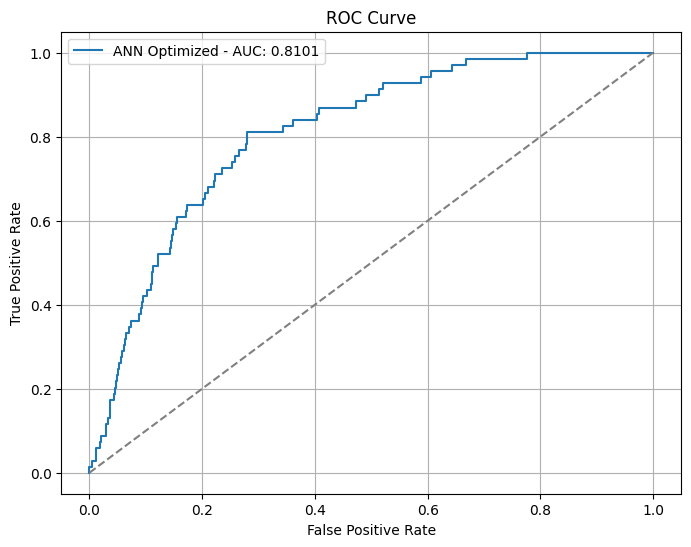

Classification Report - Test Set
              precision    recall  f1-score   support

   No Stroke       0.99      0.68      0.80      1544
      Stroke       0.10      0.81      0.18        69

    accuracy                           0.68      1613
   macro avg       0.54      0.74      0.49      1613
weighted avg       0.95      0.68      0.78      1613



| Model         |   Accuracy Test |   Precision Test |   Recall Test |   F1 Test |   AUC-ROC Test | Confusion Matrix        |
|:--------------|----------------:|-----------------:|--------------:|----------:|---------------:|:------------------------|
| ANN Optimized |        0.683819 |         0.949815 |      0.683819 |  0.777451 |       0.810121 | [[1047, 497], [13, 56]] |

In [8]:
results_list = []
test_metrics = evaluate_pipeline(
    best_model=grid_search.best_estimator_,
    X_test=X_test,
    y_test=y_test,
    results_list=results_list,
    model_name="ANN Optimized",
)

ann_results_df = pd.DataFrame(results_list)
display(Markdown(ann_results_df.to_markdown(index=False)))

## Results After Optimization

The optimization of the ANN model has achieved improvements in key areas but also introduced trade-offs in overall performance:

### **Before vs. After Optimization Comparison**

| Category               | Metric         | Before  | After    | Observation                                                                                          |
|-------------------------|---------------|---------|----------|-----------------------------------------------------------------------------------------------------|
| **AUC-ROC Test**        |               | 0.7936  | 0.8101   | Significant improvement in the ability to discriminate between classes, useful for imbalanced problems. |
| **Majority Class** `No Stroke`   | Precision     | 0.9744  | 0.99     | Marginal improvement, indicating fewer false positives for this class.                              |
|                         | Recall        | 0.8387  | 0.68     | Notable reduction in correctly identifying instances of the majority class.                         |
|                         | F1-score      | 0.9015  | 0.80     | Decrease in the balance between precision and recall.                                               |
| **Minority Class** `Stroke`  | Precision     | 0.1232  | 0.10     | Slight decrease, with more false positives for this class.                                          |
|                         | Recall        | 0.5072  | 0.81     | Drastic improvement, enhancing the detection of positive cases.                                    |
|                         | F1-score      | 0.1983  | 0.18     | Similar result, though the recall improvement compromises precision.                                |
| **Global Metrics**      | Accuracy      | 0.8245  | 0.6838     | Significant reduction due to the redistribution of the class balance.                              |
|                         | Weighted F1-score | 0.8714  | 0.78     | Reduction reflects a lower overall performance in handling both classes.                           |

### **Conclusion**
After optimization, the model has been adjusted to improve the **recall of the minority class** `Stroke`, increasing from **0.53** to **0.81**, which is critical in a clinical context where false negatives have significant consequences. However, this adjustment negatively impacted the **recall of the majority class** and global metrics such as accuracy and weighted F1-score. This reflects a shift in focus toward prioritizing the identification of positive cases at the expense of global prediction precision.

In practical applications, this configuration may be more useful if the objective is to minimize false negatives in the minority class.

# Referencias

- Angermueller, C., Pärnamaa, T., Parts, L., & Stegle, O. (2016). Deep learning for computational biology. *Molecular systems biology*, 12(7), 878.

- Bosch Rué, A., Casas Roma, J., & Lozano Bagén, T. (2019). *Deep Learning: Principios y Fundamentos*. Editorial UOC. Retrieved from [here](http://www.editorialuoc.com).

- Codecademy. (2024). *Normalization*. Retrieved from [here](https://www.codecademy.com/article/normalization).

- DataCamp. (2024). *Normalization in Machine Learning*. Retrieved from [here](https://www.datacamp.com/tutorial/normalization-in-machine-learning).

- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. *Computing in Science & Engineering*, 9(3), 90-95. doi: 10.1109/MCSE.2007.55.

- IBM. (2024). *Jupyter Notebook Markdown Cheatsheet*. Retrieved from [here](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet).

- Keras. (2024). *Keras Examples*. Retrieved from [here](https://keras.io/examples/).

- LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, 521(7553), 436-444. DOI: 10.1038/nature14539.

- Neural networks with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python).

- Scikit-learn: Machine Learning in Python. (2011). *Journal of Machine Learning Research*, 12, 2825-2830.

- TensorFlow. (2024). *tf.keras.utils.plot_model*. Retrieved from [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

- Waskom, M. L. (2021). seaborn: statistical data visualization. *Journal of Open Source Software*, 6(60), 3021. [DOI](https://doi.org/10.21105/joss.03021).

- Machine Learning with Python and Scikit-learn by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn).

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

- Calibrate machine learning models by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py11-calibrar-modelos-machine-learning).

- Machine Learning with Python and Scikitlearn by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn).

- Neural networks with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python).

- Multiple linear regression with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py10b-regresion-lineal-multiple-python).

- Using pandas category to encode categorical variables in machine learning models by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py55-pandas-category-modelos-machine-learning). 

- OpenAI Community. (2025). *Issue with accessing 'choices' attribute from OpenAI API response*. Retrieved from [here](https://community.openai.com/t/issue-with-accessing-choices-attribute-from-openai-api-response/362725).

- Ebbelaar, D. (2025). *Streamlit Chatbot Interface*. GitHub Repository. Retrieved from [here](https://github.com/daveebbelaar/streamlit-chatbot-interface/tree/main).

- OpenAI Community. (2025). *Content is a required property error (400)*. Retrieved from [here](https://community.openai.com/t/content-is-required-property-error-400/486260/2).

- Stack Overflow. (2025). *Save SHAP summary plot as PDF/SVG*. Retrieved from [here](https://stackoverflow-com.translate.goog/questions/52137579/save-shap-summary-plot-as-pdf-svg?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es-419&_x_tr_pto=sc).

- SHAP Documentation. (2025). *Overview of SHAP*. Retrieved from [here](https://shap.readthedocs.io/en/latest/overviews.html).

- Stack Overflow. (2025). *Using Python's eval() vs ast.literal_eval()*. Retrieved from [here](https://stackoverflow.com/questions/15197673/using-pythons-eval-vs-ast-literal-eval).

- PyPI. (2025). *missingno: Missing Data Visualization Module*. Retrieved from [here](https://pypi.org/project/missingno/). 

- Kokkotis, C., Giarmatzis, G., Giannakou, E., Moustakidis, S., Tsatalas, T., Tsiptsios, D., ... & Aggelousis, N. (2022). An explainable machine learning pipeline for stroke prediction on imbalanced data. *Diagnostics*, 12(10), 2392.

- Chen, T., & Guestrin, C. (2016, August). Xgboost: A scalable tree boosting system. In *Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining* (pp. 785-794).

- Grinsztajn, L., Oyallon, E., & Varoquaux, G. (2022). Why do tree-based models still outperform deep learning on typical tabular data?. *Advances in neural information processing systems*, 35, 507-520.

- Dev, S., Wang, H., Nwosu, C. S., Jain, N., Veeravalli, B., & John, D. (2022). A predictive analytics approach for stroke prediction using machine learning and neural networks. *Healthcare Analytics*, 2, 100032.

- Emon, M. U., Keya, M. S., Meghla, T. I., Rahman, M. M., Al Mamun, M. S., & Kaiser, M. S. (2020, November). Performance analysis of machine learning approaches in stroke prediction. In *2020 4th international conference on electronics, communication and aerospace technology (ICECA)* (pp. 1464-1469). IEEE.

- Paszke, A., Gross, S., Chintala, S., Chanan, G., Yang, E., DeVito, Z., Lin, Z., Desmaison, A., Antiga, L., & Lerer, A. (2017). *Automatic differentiation in PyTorch*. Retrieved from [here](https://pytorch.org/docs/).

- Fernández, A., Garcia, S., Herrera, F., & Chawla, N. V. (2018). SMOTE for learning from imbalanced data: progress and challenges, marking the 15-year anniversary. *Journal of artificial intelligence research*, 61, 863-905.

- Stack Overflow. (2025). *How does the class_weight parameter in scikit-learn work?* Retrieved from [here](https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work).

- GeeksforGeeks. (2025). *How does the class_weight parameter in scikit-learn work?* Retrieved from [here](https://www.geeksforgeeks.org/how-does-the-classweight-parameter-in-scikit-learn-work/).

- Analytics Vidhya. (2025). *Improve Class Imbalance with Class Weights*. Retrieved from [here](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/).